# 1. Setting up

In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
!nvidia-smi

Sun Feb 16 14:33:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   32C    P3              9W /   55W |      12MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Data preparation

## a) Checking images

In [3]:
import os

data_path = "data/"
test_path = data_path + "/test"
train_path = data_path + "/train"

In [4]:
def walk_through_dir(dir):
    for dirpaths, dirnames, filenames in os.walk(dir):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpaths}")
walk_through_dir(data_path)

There are 2 directories and 0 images in data/
There are 4 directories and 0 images in data/train
There are 0 directories and 274 images in data/train/Asian
There are 0 directories and 115 images in data/train/Indian
There are 0 directories and 268 images in data/train/Negroids
There are 0 directories and 117 images in data/train/Caucasian
There are 4 directories and 0 images in data/test
There are 0 directories and 69 images in data/test/Asian
There are 0 directories and 29 images in data/test/Indian
There are 0 directories and 68 images in data/test/Negroids
There are 0 directories and 30 images in data/test/Caucasian


### Check the sizes of the images

In [5]:
from PIL import Image
import os
from collections import Counter

In [6]:
size_counts = Counter()
for subfolder in os.listdir(train_path):
    subfolder_path = train_path + "/" + subfolder
    for filename in os.listdir(subfolder_path):
            file_path = subfolder_path + "/" + filename
            with Image.open(file_path) as img:
                size = img.size  # (width, height)
                size_counts[size] += 1

for size, count in size_counts.items():
    print(f'Size {size}: {count} images')

Size (224, 224): 774 images


## b) Creating transforms and datasets

In [7]:
from torchvision import transforms

img_transform = transforms.Compose([
    # transforms.Lambda(lambda img: img.convert('RGBA')), # as some img are in Palette mode
    # then turn them back into only 3 color channels
    # transforms.Lambda(lambda img: Image.new('RGB', img.size, (255, 255, 255)).paste(img, mask=img.split()[3])),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])


In [8]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_path, transform=img_transform)
test_data = datasets.ImageFolder(root=test_path, transform=img_transform)

## c) Data augmentation / preprocessing

## d) Turn datasets into dataloaders

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
num_workers = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=num_workers, shuffle=False)


# 3. Create the TinyVGG architecture model

In [10]:
from torch import nn
class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=56*56*10, out_features=output_shape)
        )
    def forward(self, x):
        return self.classifier(self.conv_block2(self.conv_block1(x)))

In [11]:
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_data.classes))
model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=4, bias=True)
  )
)

# 4. Training and testing

## Train step and test step function

In [12]:
import torch.utils.data.dataloader


def train_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, 
          optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc= 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        train_loss += loss.cpu().detach().numpy() # for plotting loss in matplotlib later(requires numpy arr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)
        train_acc += (labels == y).sum().item()/len(y)
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [13]:
def test_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module ):
    model.eval()
    test_loss, test_acc = 0, 0 
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            test_loss += loss.cpu().detach().numpy() # for plotting loss in matplotlib later(requires numpy arr)

            labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)
            test_acc += (labels == y).sum().item() / len(y)
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss, test_acc


## Train function

In [14]:
from tqdm.auto import tqdm
def train(model: nn.Module, train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(), epochs: int = 1, device = device):
  model.to(device)
  result = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
  }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, optimizer=optimizer, loss_fn=loss_fn)
    test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn)

    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")
    result["train_loss"].append(train_loss)
    result["train_acc"].append(train_acc)
    result["test_loss"].append(test_loss)
    result["test_acc"].append(test_acc)
  return result

## Train the model

In [19]:
torch.manual_seed(27)
torch.cuda.manual_seed(27)

NUM_EPOCHS = 30

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

from timeit import default_timer as timer
start_time = timer()
model_0_result = train(model=model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                       optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS)
end_time = timer()
print(f"Total training time on {device}: {end_time - start_time}")


  0%|          | 0/30 [00:00<?, ?it/s]

/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1 | Train loss: 1.3013 | Train acc: 0.3642 | Test loss: 1.2745 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 2 | Train loss: 1.3014 | Train acc: 0.3479 | Test loss: 1.2757 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 3 | Train loss: 1.3063 | Train acc: 0.3329 | Test loss: 1.2712 | Test acc: 0.4286


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 4 | Train loss: 1.3095 | Train acc: 0.3446 | Test loss: 1.2760 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 5 | Train loss: 1.3011 | Train acc: 0.3588 | Test loss: 1.2760 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 6 | Train loss: 1.3007 | Train acc: 0.3533 | Test loss: 1.2759 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 7 | Train loss: 1.3055 | Train acc: 0.3588 | Test loss: 1.2742 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 8 | Train loss: 1.3059 | Train acc: 0.3479 | Test loss: 1.2756 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 9 | Train loss: 1.3007 | Train acc: 0.3362 | Test loss: 1.2720 | Test acc: 0.4286


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 10 | Train loss: 1.3004 | Train acc: 0.3500 | Test loss: 1.2734 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 11 | Train loss: 1.3007 | Train acc: 0.3538 | Test loss: 1.2746 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 12 | Train loss: 1.3003 | Train acc: 0.3588 | Test loss: 1.2752 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 13 | Train loss: 1.3047 | Train acc: 0.3533 | Test loss: 1.2746 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 14 | Train loss: 1.3096 | Train acc: 0.3279 | Test loss: 1.2742 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 15 | Train loss: 1.3099 | Train acc: 0.3533 | Test loss: 1.2751 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 16 | Train loss: 1.3014 | Train acc: 0.3642 | Test loss: 1.2752 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 17 | Train loss: 1.3056 | Train acc: 0.3588 | Test loss: 1.2763 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 18 | Train loss: 1.3103 | Train acc: 0.3533 | Test loss: 1.2758 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 19 | Train loss: 1.2960 | Train acc: 0.3642 | Test loss: 1.2756 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 20 | Train loss: 1.3145 | Train acc: 0.3533 | Test loss: 1.2756 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 21 | Train loss: 1.3106 | Train acc: 0.3479 | Test loss: 1.2774 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 22 | Train loss: 1.3009 | Train acc: 0.3533 | Test loss: 1.2758 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 23 | Train loss: 1.3008 | Train acc: 0.3533 | Test loss: 1.2729 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 24 | Train loss: 1.3009 | Train acc: 0.3463 | Test loss: 1.2728 | Test acc: 0.4286


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 25 | Train loss: 1.3054 | Train acc: 0.3458 | Test loss: 1.2735 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 26 | Train loss: 1.2958 | Train acc: 0.3588 | Test loss: 1.2733 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 27 | Train loss: 1.3148 | Train acc: 0.3479 | Test loss: 1.2736 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 28 | Train loss: 1.3098 | Train acc: 0.3171 | Test loss: 1.2729 | Test acc: 0.4286


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 29 | Train loss: 1.3053 | Train acc: 0.3304 | Test loss: 1.2744 | Test acc: 0.3080


/home/nerfeddoge/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 30 | Train loss: 1.3142 | Train acc: 0.3425 | Test loss: 1.2752 | Test acc: 0.3080
Total training time on cuda: 79.61947396300002


# 5. Evaluating the model

In [16]:
import matplotlib.pyplot as plt

In [17]:
def plot_loss_curve(result):
    """Plot the training and test loss/acc curve from a dictionary"""
    train_loss = result["train_loss"]
    test_loss = result["test_loss"]
    train_acc = result["train_acc"]
    test_acc = result["test_acc"]
    epochs = range(len(train_loss))

    plt.figure(figsize=(10,6))
    # Plot the loss 
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, test_loss, label="Test loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2 ,2)
    plt.plot(epochs, train_acc, label="Train acc")
    plt.plot(epochs, test_acc, label="Test acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

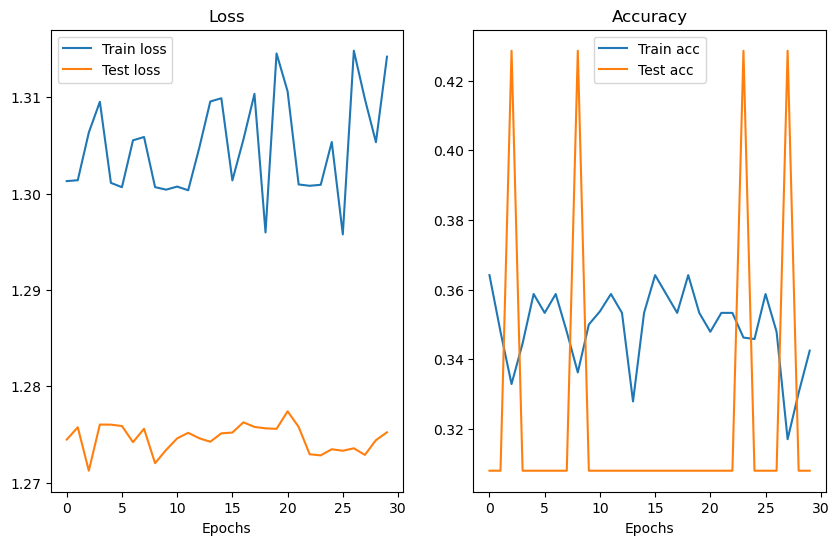

In [20]:
plot_loss_curve(model_0_result)